In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, \
    IDF, StringIndexer
from pyspark.sql.functions import udf, row_number
from pyspark.sql.types import IntegerType
import re
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import Window
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType

from sklearn.preprocessing import FunctionTransformer
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType

from pyspark.sql.utils import AnalysisException
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import pandas as pd

import re

In [2]:
spark = SparkSession.builder \
    .master("local") \
    .appName("data_analysis") \
    .getOrCreate()

# Data Cleaning

I first clean the data a little bit for the data analysis.

In [3]:
def data_preclean(input_df):
    # cleanse stringtype fields from special characters
    for field in input_df.schema.fields:
        if field.dataType==StringType():
            input_df = input_df.withColumn(field.name, F.regexp_replace(field.name, '[^a-zA-Z0-9\,\-]', ''))
    # create new ts related columns
    input_df = input_df.withColumn('interaction_time', 
                                   F.from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
    input_df = input_df.withColumn('month', F.month(col('interaction_time')))
    input_df = input_df.withColumn('date', F.from_unixtime(col('ts')/1000).cast(DateType()))    
    input_df = input_df.withColumn('userId', col('userId').cast(LongType()))
    # remove user id null
    input_df = input_df.filter(col('userId').isNotNull())
    # filter out log out records
    input_df = input_df.filter(~col('auth').isin(['LoggedOut','Logged Out','Guest']))
    # replace location with extracting state from it
    input_df = input_df.withColumn('state', split(col('location'),',').getItem(1))    
    return input_df

stack_overflow_data = '..\sample_data\mini_sparkify_event_data.json'
df = spark.read.json(stack_overflow_data)
df.persist()
print(df.printSchema())
preclean_size = df.count()

preclean_transformer = FunctionTransformer(data_preclean, validate=False)
df = preclean_transformer.transform(df)
cleaned_size = df.count()
print('pre clean data has {} row and post clean data has {} rows'.format(preclean_size, cleaned_size))
min_date, max_date = df.select(F.min("date"), F.max("date")).first()
print('data range from {} to {} '.format(min_date, max_date))
df.head()

### calculcate some key measures
unique_ids = [i['userId'] for i in df.select('userId').distinct().collect()]
print('there are {} total users in the data with size {}'.format(len(unique_ids), df.count()))

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

None
pre clean data has 286500 row and post clean data has 278154 rows
data range from 2018-09-30 to 2018-12-02 
there are 225 total users in the data with size 278154


In [4]:
def has_column(df, col):
    try:
        df[col]
        return True
    except AnalysisException:
        return False
    
def target_labelling(input_df):
    window = Window.partitionBy(input_df['userId']).orderBy(input_df['ts'].desc())
    label_df =\
        input_df.select('userId', 'page', 'auth',F.row_number().over(window).alias('rank')) \
            .filter(col('rank') <= 1)
    label_df = label_df.withColumn('label',
                                   F.when((col('page').isin(['CancellationConfirmation','Cancel']))
                                        |(col('auth')=='Cancelled'),1).otherwise(0))
    label_df = label_df.select('userId','label')
    if has_column(input_df, 'label'):
        input_df = input_df.drop('label')
    input_df = input_df.join(label_df, on='userId',how='left')
    return input_df
label_transformer = FunctionTransformer(target_labelling, validate=False)


print(df.count())
df = label_transformer.transform(df)
df.head()
print(df.count())


def moving_window_features(input_df):
    input_df = input_df.withColumn('time_since_register',
                        ((col('ts')-col('registration'))/86400000).cast(IntegerType()))
    sessionStarts = input_df.orderBy(['userID','sessionId','ts'],ascending=True).\
                        groupby(['userID','sessionId']).\
                        agg(F.first('ts').alias('sessionStart'))
    sessionStarts.orderBy(['userID','sessionStart'], ascending=True)
    windowval = (Window.partitionBy('userID').orderBy('sessionStart')
             .rangeBetween(Window.unboundedPreceding, 0))
    sessionStarts = sessionStarts.withColumn('session_count',F.count('sessionId').over(windowval))
    input_df = input_df.join(sessionStarts,on=['userID','sessionId'])
    return input_df
moving_window_features_transformer = FunctionTransformer(moving_window_features, validate=False)
df = moving_window_features_transformer.transform(df)
df.head()
print(df.count())

278154
278154
278154


In [123]:
## calculation for viz

window = Window.partitionBy(df['userId']).orderBy(df['ts'].desc())
user_final_status =\
    df.select('userId', 'page', 'auth','date','ts','label', 'state', 'level', 'method', F.row_number().over(window).alias('rank')) \
        .filter(col('rank') <= 1) \
        .toPandas()

window = Window.partitionBy(df['userId']).orderBy(df['ts'])
user_first_status =\
    df.select('userId', 'page', 'auth','date','ts','label', 'state', 'level', 'method',  F.row_number().over(window).alias('rank')) \
        .filter(col('rank') <= 1) \
        .toPandas()

user_status_change = pd.concat([user_first_status, user_final_status])
user_status_change = user_status_change.sort_values(['userId','ts'])

location_activities = df.groupBy('state').count().orderBy('count', ascending=False).toPandas()
level_count_activities = df.groupBy('level').count().orderBy('count', ascending=False).toPandas()
method_count_activities = df.groupBy('method').count().orderBy('count', ascending=False).toPandas()

window = Window.partitionBy(df['userId']).orderBy(df['ts'].desc())
user_final_status_check =\
    df.select('userId', 'page', 'auth','date','ts','label',  'state', 'level', 'method', F.row_number().over(window).alias('rank')) \
        .filter(col('rank') <= 1) \
        .toPandas()

ts_from_register_df = df.filter(col('page').isin(['CancellationConfirmation','Cancel'])).select('time_since_register').toPandas()

# Data Analysis

We first example the user status to find out who has left. As shown below, it seems we just need to flag those who visit cancel pages.

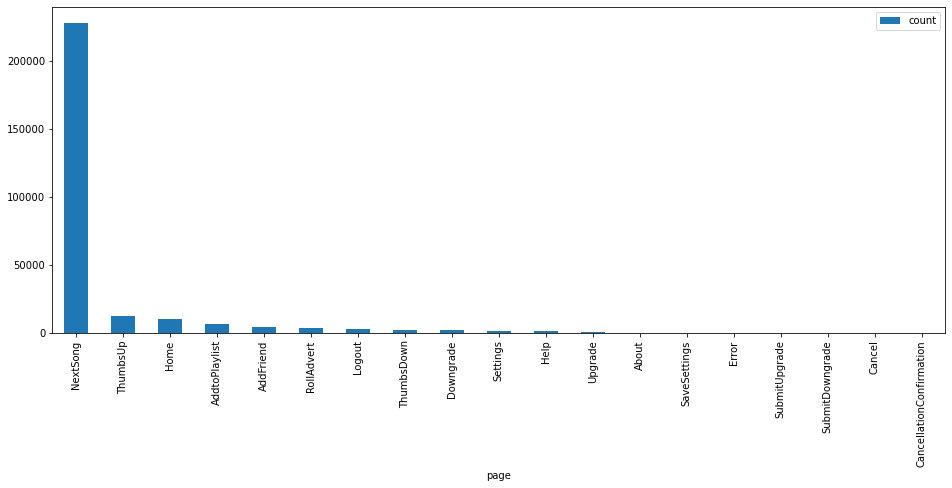

In [14]:
fig, ax = plt.subplots(figsize=(16,6))
location_activities.set_index('page').plot(ax=ax,kind='bar')

then we could have a look on the user attributions such as location, etc.

C:\Users\Muxi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Muxi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Muxi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Muxi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:314: MatplotlibDeprecationWarning

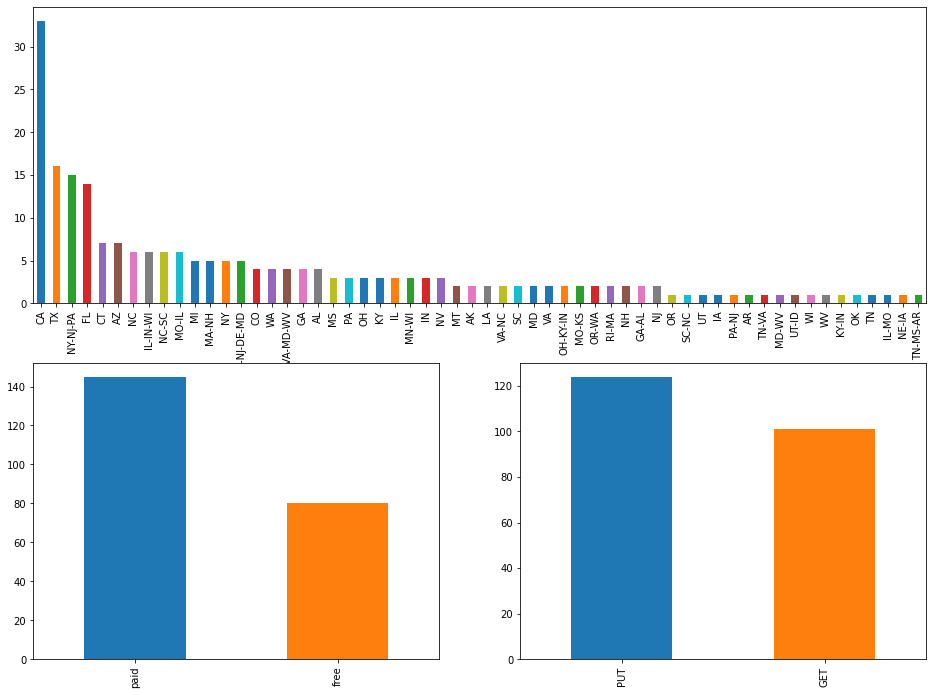

In [101]:
# we first example the status of the users. 
fig, ax = plt.subplots(2,2, figsize=(16,12))

ax = plt.subplot(2, 1, 1)
# df = df.withColumn('state', split(col('location'),',').getItem(1))    
location = user_final_status['state'].value_counts()
location.plot(ax=ax,kind='bar')
    
ax = plt.subplot(2, 2, 3)
level_count = user_final_status['level'].value_counts()
# level_count = df.groupBy('level').count().orderBy('count', ascending=False).toPandas()
level_count.plot( ax=ax,kind='bar')
    
ax = plt.subplot(2, 2, 4)
method_count = user_final_status['method'].value_counts()
method_count.plot( ax=ax,kind='bar')
# method_count = df.groupBy('method').count().orderBy('count', ascending=False).toPandas()
# method_count.set_index('method').plot(ax=ax, kind='bar')


C:\Users\Muxi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Muxi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Muxi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Muxi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:314: MatplotlibDeprecationWarning

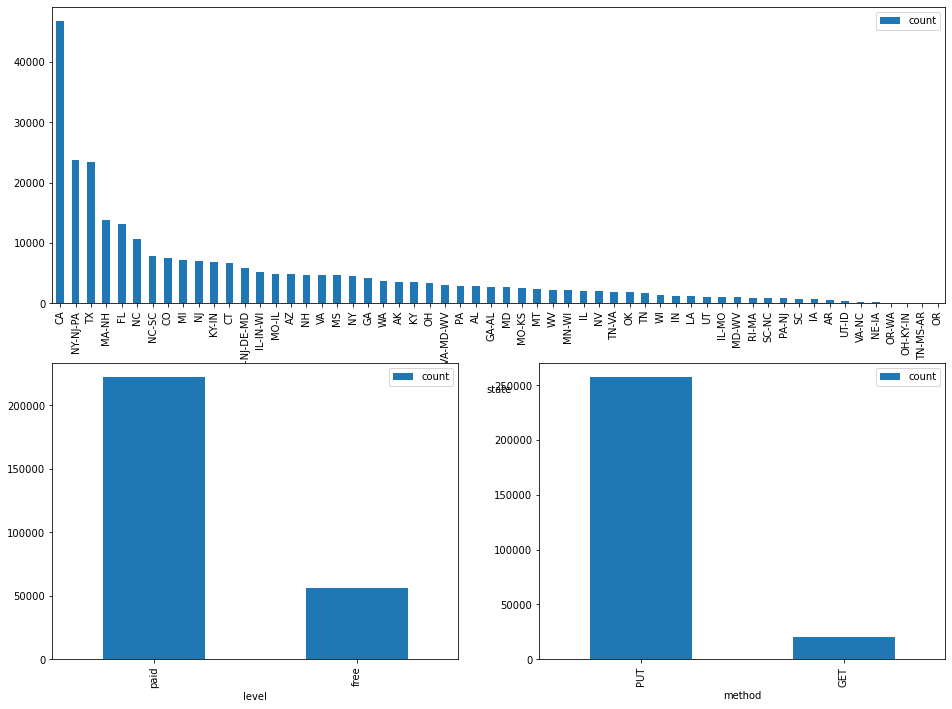

In [106]:
# we first example the status of the users. 
fig, ax = plt.subplots(2,2, figsize=(16,12))

ax = plt.subplot(2, 1, 1)
location_activities.set_index('state').plot(ax=ax,kind='bar')
    
ax = plt.subplot(2, 2, 3)
level_count_activities.set_index('level').plot( ax=ax,kind='bar')
    
ax = plt.subplot(2, 2, 4)
method_count_activities.set_index('method').plot(ax=ax, kind='bar')


it looks those users just submit cancel in the 'cancel' page and then nivagate to 'Cancel Confirmation' page.

In [108]:
user_status_change.head()

,userId,page,auth,date,ts,rank
131,2,NextSong,LoggedIn,2018-10-08,1538974195000,1
131,2,AddFriend,LoggedIn,2018-11-21,1542839404000,1
106,3,NextSong,LoggedIn,2018-10-02,1538532534000,1
106,3,CancellationConfirmation,Cancelled,2018-10-30,1540875543000,1
144,4,NextSong,LoggedIn,2018-09-30,1538356650000,1


In [109]:
cancelled_ids = user_status_change.loc[user_status_change['page'].isin(['CancellationConfirmation','Cancel']),
                                       'userId'].unique()
cancelled_user_log = user_status_change.loc[user_status_change['userId'].isin(cancelled_ids),:]
cancelled_user_log.head()

,userId,page,auth,date,ts,rank
106,3,NextSong,LoggedIn,2018-10-02,1538532534000,1
106,3,CancellationConfirmation,Cancelled,2018-10-30,1540875543000,1
113,12,Home,LoggedIn,2018-10-02,1538533887000,1
113,12,CancellationConfirmation,Cancelled,2018-10-22,1540193374000,1
59,17,Home,LoggedIn,2018-10-03,1538543419000,1


In [112]:

user_final_status['label'] = 0
user_final_status.loc[user_final_status['page'].isin(['CancellationConfirmation','Cancel']), 
                      'label'] = 1
print(user_final_status_check['label'].mean(),user_final_status['label'].mean())

0.2311111111111111 0.2311111111111111


In [94]:
chun_rt = df.select('label').agg(F.mean(col('label'))).collect()[0]['avg(label)']
print('end to end chun rt {:.2f}'.format(round(float(chun_rt*100), 2)))

end to end chun rt 16.13


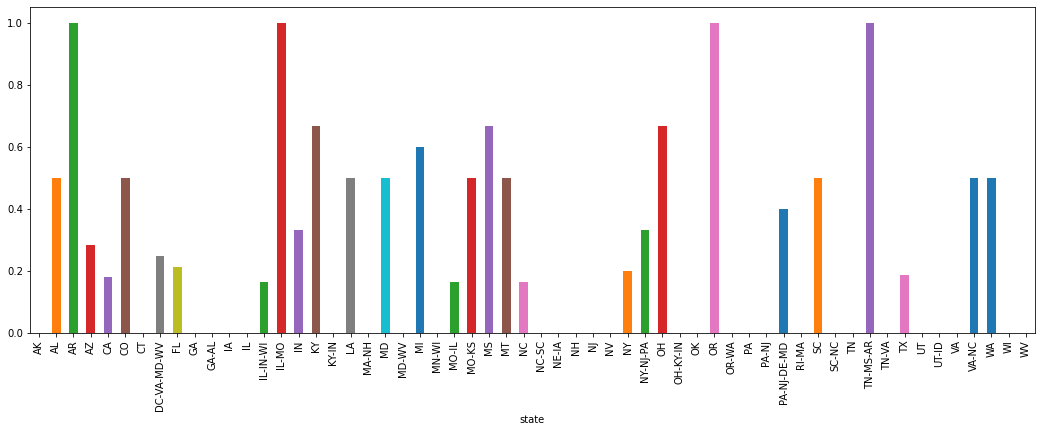

In [119]:
# from pyspark.sql import functions as F
location = user_final_status.groupby(['state'])['label'].mean()
location.plot(figsize=(18,6), kind='bar')

C:\Users\Muxi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Muxi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Muxi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Muxi\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:314: MatplotlibDeprecationWarning

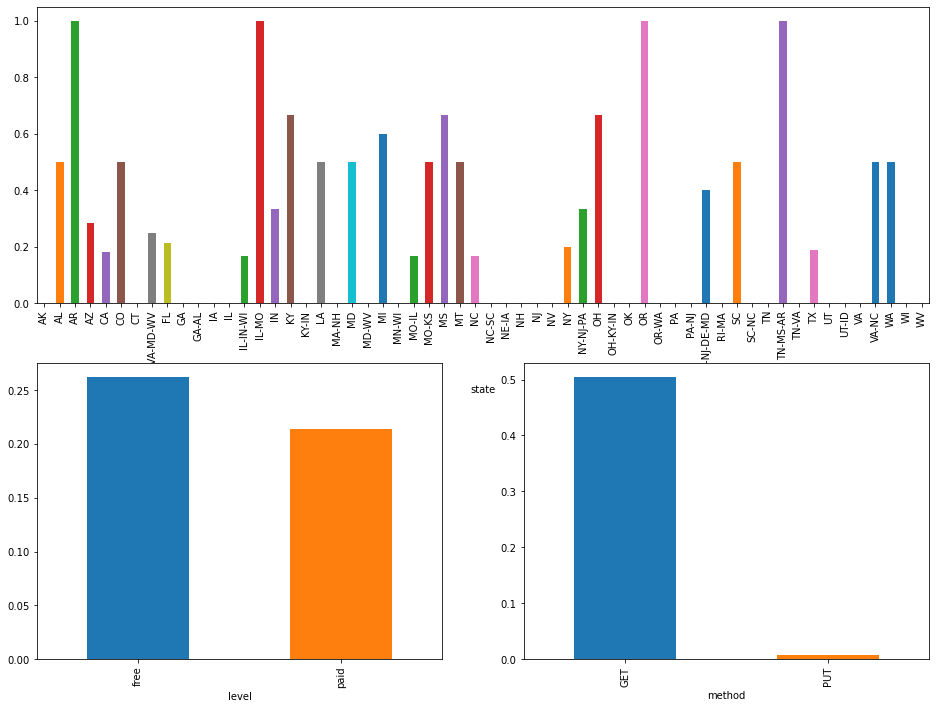

In [124]:
# we first example the status of the users. 
fig, ax = plt.subplots(2,2, figsize=(16,12))

ax = plt.subplot(2, 1, 1)
# df = df.withColumn('state', split(col('location'),',').getItem(1))    
location = user_final_status.groupby(['state'])['label'].mean()
location.plot(ax=ax,kind='bar')

ax = plt.subplot(2, 2, 3)
level_count = user_final_status.groupby(['level'])['label'].mean()
# level_count = df.groupBy('level').count().orderBy('count', ascending=False).toPandas()
level_count.plot( ax=ax,kind='bar')

ax = plt.subplot(2, 2, 4)
method_count = user_final_status.groupby(['method'])['label'].mean()
method_count.plot( ax=ax,kind='bar')

In [127]:

print(df.count())
# df.head()

278154


Row(userId=37, sessionId=504, artist=None, auth='LoggedIn', firstName='Jadyn', gender='M', itemInSession=0, lastName='Rose', length=None, level='free', location='Austin-RoundRock,TX', method='GET', page='Home', registration=1535268719000, song=None, status=200, ts=1539621183000, userAgent='Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML,likeGeckoChrome3601985143Safari53736', interaction_time=datetime.datetime(2018, 10, 15, 12, 33, 3), month=10, date=datetime.date(2018, 10, 15), state='TX', label=0, time_since_register=50, sessionStart=1539621183000, session_count=2)

In [129]:

ts_from_register_df.hist(figsize=(12,6),bins=50)

,time_since_register
0,55
1,55
2,9
3,9
4,31


# Feature Engineering

In [7]:
# def data_preclean(input_df):
#     # cleanse stringtype fields from special characters
#     for field in input_df.schema.fields:
#         if field.dataType==StringType():
#             input_df = input_df.withColumn(field.name, regexp_replace(field.name, '[^a-zA-Z0-9\,\-]', ''))
#     # create new ts related columns
#     input_df = input_df.withColumn('interaction_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
#     input_df = input_df.withColumn('month', month(col('interaction_time')))
#     input_df = input_df.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
    
#     input_df = input_df.withColumn('userId', col('userId').cast(LongType()))
#     # remove user id null
#     input_df = input_df.filter(col('userId').isNotNull())
#     # filter out log out records
#     input_df = input_df.filter(~col('auth').isin(['LoggedOut','Logged Out','Guest']))
#     # replace location with extracting state from it
#     input_df = input_df.withColumn('state', split(col('location'),',').getItem(1))    
#     return input_df


def target_labelling(input_df):
    label_df = input_df.withColumn('label',
                                   when((col('page').isin(['Cancellation Confirmation','Cancel']))
                                        |(col('auth')=='cancelled'),1).otherwise(0))
    label_df = label_df.groupby('userID').agg(sum('label').alias('label')).\
                        withColumn('label', when(col('label')>=1,1).otherwise(0))
    input_df = input_df.join(label_df, on='userID')
    return input_df

def moving_window_features(input_df):
    input_df = input_df.withColumn('time_since_register',
                        ((col('ts')-col('registration'))/86400000).cast(IntegerType()))
    sessionStarts = input_df.orderBy(['userID','sessionId','ts'],ascending=True).\
                        groupby(['userID','sessionId']).\
                        agg(first('ts').alias('sessionStart'))
    sessionStarts.orderBy(['userID','sessionStart'], ascending=True)
    windowval = (Window.partitionBy('userID').orderBy('sessionStart')
             .rangeBetween(Window.unboundedPreceding, 0))
    sessionStarts = sessionStarts.withColumn('session_count',count('sessionId').over(windowval))
    input_df = input_df.join(sessionStarts,on=['userID','sessionId'])
    return input_df
moving_window_features_transformer = FunctionTransformer(moving_window_features, validate=False)
df = moving_window_features_transformer.transform(df)

In [8]:
# label_transformer = FunctionTransformer(target_labelling, validate=False)
# df = label_transformer.transform(df)
# df = df.fillna(0, subset=['length'])

In [134]:
def generate_training_data(features_df):
    """
    Transforms features with feature pipeline
    :param features_df: Spark DataFrame of features
    :return Spark Dataframe with label and assembled features
    """
    num_cols = []
    
    for field in features_df.schema.fields :
        if field.dataType!=StringType():
            num_cols.append(field.name)

#     num_cols.remove('label')
#     num_cols.remove('interaction_time')
    num_cols = [item for item in num_cols if item not in ['label','ts', 'interaction_time', 
                                                          'sessionStart' ,'registration', 'date']]
    print(num_cols)
    indexer_gender = StringIndexer(inputCol='gender', outputCol='gender_index').setHandleInvalid("keep")
    indexer_location = StringIndexer(inputCol='location', outputCol='location_index').setHandleInvalid("keep")
#     indexer_valid_level = StringIndexer(inputCol='valid_level', outputCol='valid_level_index')

    assembler = VectorAssembler(inputCols=num_cols+['gender_index', 'location_index'], 
                                outputCol='features').setHandleInvalid("keep")

    process_pipeline = Pipeline(stages=[indexer_gender, indexer_location,  assembler])
#     process_pipeline = build_pipeline(num_cols)
    model_df = process_pipeline.fit(features_df).transform(features_df)
#     return model_df.select("label", "features")
    return model_df

model_df = generate_training_data(df)

['userId', 'itemInSession', 'length', 'sessionId', 'status', 'month']


# Model Training

In [15]:
train, test = model_df.randomSplit([0.9, 0.1], seed=42)
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[lr])

paramsGrid = ParamGridBuilder()\
                .addGrid(lr.regParam,[0.0,0.1])\
                .addGrid(lr.maxIter,[10,50])\
                .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramsGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

cvModel = crossval.fit(train)
cvModel.avgMetrics

[0.7353642130361494,
 0.7751738854093617,
 0.7335633920592196,
 0.7643379912485221]

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
pipeline = Pipeline(stages=[rf])

paramsGrid = ParamGridBuilder()\
                .addGrid(rf.numTrees,[100,500])\
                .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramsGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

cvModel = crossval.fit(train)
cvModel.avgMetrics

In [ ]:
cvModel.predict()

## Appendix

In [17]:
df2.select([count(when(isnan(c), c)).alias(c) for c in num_cols]).show()

+-------------+------+------+-----+-------------------+-------------+
|itemInSession|length|status|month|time_since_register|session_count|
+-------------+------+------+-----+-------------------+-------------+
|            0|     0|     0|    0|                  0|            0|
+-------------+------+------+-----+-------------------+-------------+



In [19]:
num_cols = ['itemInSession',
 'length',
 'status',
 'month',
 'time_since_register',
 'session_count']
assembler = VectorAssembler(inputCols=num_cols, outputCol='features2').setHandleInvalid("keep")
df3 = assembler.transform(df2)
df3.head()

Row(userId=37, sessionId=504, artist=None, auth='LoggedIn', firstName='Jadyn', gender='M', itemInSession=0, lastName='Rose', length=None, level='free', location='TX', method='GET', page='Home', registration=1535268719000, song=None, status=200, ts=1539621183000, userAgent='Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML,likeGeckoChrome3601985143Safari53736', interaction_time=datetime.datetime(2018, 10, 15, 12, 33, 3), month=10, date=datetime.date(2018, 10, 15), label=0, time_since_register=50, sessionStart=1539621183000, session_count=2, gender_index=1.0, location_index=2.0, features2=DenseVector([0.0, nan, 200.0, 10.0, 50.0, 2.0]))

In [58]:
count_df = df.groupBy('auth').count().orderBy('count', ascending=False)
count_df.collect()
print(count_df.count())
count_df.head(5)

2


[Row(auth='LoggedIn', count=278102), Row(auth='Cancelled', count=52)]

In [11]:
count_df = df.groupBy('gender').count().orderBy('count', ascending=False)
count_df.collect()
print(count_df.count())
count_df.head(5)

3


[Row(gender='F', count=154578),
 Row(gender='M', count=123576),
 Row(gender=None, count=8346)]

In [12]:
count_df = df.groupBy('level').count().orderBy('count', ascending=False)
count_df.collect()
print(count_df.count())
count_df.head(5)

2


[Row(level='paid', count=228162), Row(level='free', count=58338)]